# Homework 3 (ADM) - Michelin restaurants in Italy

Author: Viktoriia Vlasenko  

Email: [vlasenko.2088928@studenti.uniroma1.it](mailto:vlasenko.2088928@studenti.uniroma1.it)

***

## 1. Data collection

For this homework, to improve readability in reporting and efficiency in deploying the code I created ```crawler.py```, ```parser.py```, and ```engine.py``` modules.

In [49]:
import importlib
import crawler
import parser
import engine
import visualiser

# Reload the modules
importlib.reload(crawler)
importlib.reload(parser)
importlib.reload(engine)
importlib.reload(visualiser)

# Setup engine: downloads all necessary packages
engine.setup()

import os
from tqdm import tqdm
import json
import re

# Geolocations
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)


Error applying WordNet fix: [WinError 2] The system cannot find the file specified


[nltk_data] Downloading package punkt to C:\Users\vikto...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\vikto...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\vikto...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\vikto...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to C:\Users\vikto...
[nltk_data]   Package wordnet2022 is already up-to-date!


### 1.1. Get the list of Michelin restaurants

`scrapling()` is a function which web scraples  Michelin's restaurant pages, retrieving restaurant URLs.



The function creates `restaurants.txt` file for  storing the results with URLs.




In [3]:
help(crawler.scraping)


Help on function scraping in module crawler:

scraping(filename='restaurants.txt', n_pages=100)
    Crawls restaurant links from Michelin's website and saves them to a text file.
    Args:
        filename (str): Name of the file to save the restaurant URLs.
        n_pages (int): Number of pages to scrape.
    This function scrapes restaurant listing pages and extracts links for individual
    restaurant pages. Each URL is written to a new line in `filename`.



In [ ]:
# Get the list of Michelin restaurants in 'restaurants.txt'
crawler.scraping()


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


As the result of scraping I retrieved 1982 URLs of Michelin's restaurant pages.

### 1.2. Crawl Michelin restaurant pages



`crawl_restaurants()` is a function that reads URLs from `restaurants.txt` and download each page's HTML content.

For each URL, it calls `commit_html()`, which downloads the HTML and saves it to a file. This approach should prevent a data lose if the execution stops unexpectedly.



<u>**Files structure organization**</u>:



.html files are stored in their folder by number of the page from which they were scrapped.



<u>**Shorten the proccess**</u>

* `commit_html()` uses `aiohttp`:

    * `aiohttp.ClientSession` is used to perform asynchronous HTTP requests, allowing multiple pages to be fetched concurrently.

    * `await response.read()` fetches the content without blocking other requests, so pages download in parallel.

* `crawl_restaurants()` uses `asyncio.gather`:

    * `asyncio.gather` run all `commit_html()` calls concurrently, improving efficiency.

In [4]:
help(crawler.commit_html)


Help on function commit_html in module crawler:

async commit_html(session: aiohttp.client.ClientSession, folder_number: int, restaurant_name: str, url: str) -> int
    Asynchronously downloads and saves the HTML content of a Michelin restaurant page.

    Args:
        session (ClientSession): The aiohttp session for making requests.
        folder_number (int): The folder number to categorize saved HTML files.
        restaurant_name (str): The name of the restaurant, used as the filename for the HTML.
        url (str): The full URL of the Michelin restaurant page.

    Returns:
        int: 0 if the HTML was downloaded and saved successfully, 1 if any exception occurred.



In [5]:
help(crawler.crawl_restaurants)


Help on function crawl_restaurants in module crawler:

async crawl_restaurants(base_filename: str = 'restaurants.txt', n_cards: int = 20)
    Crawls Michelin restaurant URLs from a text file and saves each page's HTML locally,
    with retries for any failed folders.

    Args:
        base_filename (str): Path to the text file containing restaurant URLs.
        n_cards (int): Number of restaurant URLs to process per page.



In [ ]:
# Use async approach
await crawler.crawl_restaurants(base_filename = crawler.FILENAME)


CURRENT PAGE: 1
Processing folder 1, attempt 1/3
Folder 1 downloaded successfully.
Folder 1 completed successfully.
CURRENT PAGE: 2
Processing folder 2, attempt 1/3
Folder 2 downloaded successfully.
Folder 2 completed successfully.
CURRENT PAGE: 3
Processing folder 3, attempt 1/3
Folder 3 downloaded successfully.
Folder 3 completed successfully.
CURRENT PAGE: 4
Processing folder 4, attempt 1/3
Folder 4 downloaded successfully.
Folder 4 completed successfully.
CURRENT PAGE: 5
Processing folder 5, attempt 1/3
Folder 5 downloaded successfully.
Folder 5 completed successfully.
CURRENT PAGE: 6
Processing folder 6, attempt 1/3
Folder 6 downloaded successfully.
Folder 6 completed successfully.
CURRENT PAGE: 7
Processing folder 7, attempt 1/3
Folder 7 downloaded successfully.
Folder 7 completed successfully.
CURRENT PAGE: 8
Processing folder 8, attempt 1/3
Folder 8 downloaded successfully.
Folder 8 completed successfully.
CURRENT PAGE: 9
Processing folder 9, attempt 1/3
Folder 9 downloaded suc

1981


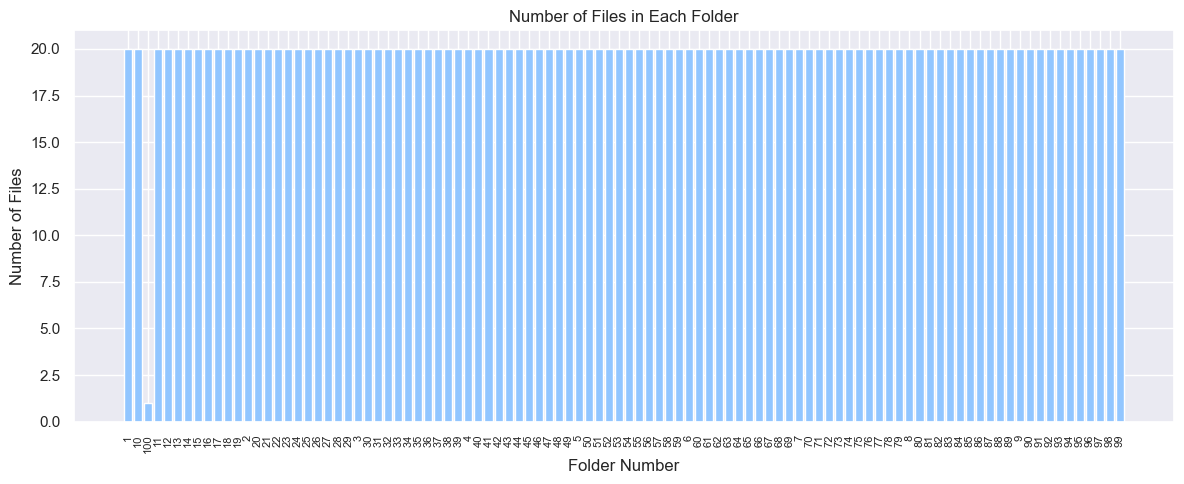

In [ ]:
restaurants_path = crawler.ROOT_FOLDER

# Initialize a dictionary to store the count of files in each folder
folder_file_counts = {}
# List of all files paths
file_paths = []

# Iterate over each folder in the specified directory
for folder_name in os.listdir(restaurants_path):
    folder_path = os.path.join(restaurants_path, folder_name)
    if os.path.isdir(folder_path):
        # Add paths to the list
        file_paths.extend([os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path)])
        # Count the number of files in the current folder
        file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        folder_file_counts[folder_name] = file_count

# Sort the dictionary by folder name (for a cleaner plot)
folder_file_counts = dict(sorted(folder_file_counts.items()))

# Print total number of crawled files
print(sum(folder_file_counts.values()))

# Plotting
plt.figure(figsize=(12, 5))
plt.bar(folder_file_counts.keys(), folder_file_counts.values())
plt.xlabel('Folder Number')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Folder')
plt.xticks(rotation=90, fontsize=8)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()


### 1.3 Parse downloaded pages



From the downloaded files I'm extracting following information about the restaurants:



1. **Restaurant Name** (to save as `restaurantName`): string;

2. **Address** (to save as `address`): string;

3. **City** (to save as `city`): string;

4. **Postal Code** (to save as `postalCode`): string;

5. **Country** (to save as `country`): string;

6. **Price Range** (to save as `priceRange`): string;

7. **Cuisine Type** (to save as `cuisineType`): string;

8. **Description** (to save as `description`): string;

9. **Facilities and Services** (to save as `facilitiesServices`): list of strings;

10. **Accepted Credit Cards** (to save as `creditCards`): list of strings;

11. **Phone Number** (to save as `phoneNumber`): string;

12. **URL to the Restaurant Page** (to save as `website`): string.

I created two specific function that are covering following approaches:

* `extract_restaurant_data()` is parsing one single .html file into a dictionary with a scructure below.

* `write_restaurant_data_to_tsv()` is function for writing parsed results into `restaurant_i.tsv` file.

In [6]:
help(parser.extract_restaurant_data)


Help on function extract_restaurant_data in module parser:

extract_restaurant_data(html_file_path)
    Extracts structured data for a restaurant from an HTML file using BeautifulSoup.

    This function opens and parses an HTML file containing details about a restaurant,
    then extracts specific data points (e.g., name, address, price range) by looking for
    HTML elements and attributes associated with each field. If a 403 Forbidden error is
    detected in the HTML, it returns None to skip processing for that file.

    Args:
        html_file_path (str): The path to the HTML file to parse.

    Returns:
        dict or None: A dictionary containing the restaurant's data if parsing is successful,
                      or None if the file is inaccessible or data extraction fails.
                      The dictionary includes the following keys:
                        - "restaurantName" (str): The name of the restaurant.
                        - "address" (str): The street addres

In [7]:
help(parser.write_restaurant_data_to_tsv)


Help on function write_restaurant_data_to_tsv in module parser:

write_restaurant_data_to_tsv(output_file_path, file_paths)
    Writes extracted restaurant data to a TSV file, handling missing values by converting them to empty strings.

    Args:
        output_file_path (str): The path to the output TSV file.
        file_paths (list of str): List of file paths to HTML files to process.

    The function writes the data in a tab-separated format with headers at the top. Each row corresponds
    to a restaurant, with empty values where data is missing to ensure consistent column alignment. The
    function appends data to the file if it already exists, adding headers only if the file is new or empty.

    Functionality:
        - For each HTML file in file_paths, extracts restaurant data using `extract_restaurant_data`.
        - Writes a row to the TSV file for each restaurant, with missing fields represented as empty strings.
        - Skips entries if a 403 error is detected in the

In [ ]:
# Wrap file_paths with tqdm for progress tracking
file_paths_with_progress = (file_path for file_path in tqdm(file_paths, desc="Processing files", unit="file"))
parser.write_restaurant_data_to_tsv(output_file_path = crawler.TSV_FILENAME, file_paths = file_paths_with_progress)


Processing files: 100%|██████████| 1981/1981 [03:14<00:00, 10.20file/s]

Reprocessed files: set()


**Loading the data into the data frame**

In [8]:
# Load the tsv file into a DataFrame
restaurants = pd.read_csv(
    crawler.TSV_FILENAME, 
    sep='\t',
    dtype={
        "restaurantName": "str",
        "address": "str",
        "city": "str",
        "postalCode": "str",
        "country": "str",
        "priceRange": "str",
        "cuisineType": "str",
        "description": "str",
        "facilitiesServices": "str",
        "creditCards": "str",
        "phoneNumber": "str",
        "website": "str"
    })

# Add a new index column
restaurants.index = range(1, len(restaurants) + 1)
restaurants.index.name = 'index'

# Print head 3
restaurants.head(3)


,restaurantName,address,city,postalCode,country,priceRange,cuisineType,description,facilitiesServices,creditCards,phoneNumber,website
index,,,,,,,,,,,,
1,20Tre,via David Chiossone 20 r,Genoa,16123,Italy,€€,"Farm to table, Modern Cuisine","Run by three partners, this contemporary-style...",['Air conditioning'],"['amex', 'dinersclub', 'mastercard', 'visa']",+39 010 247 6191,https://www.ristorante20tregenova.it/
2,Alessandro Feo,via Angelo Lista 24,Marina di Casal Velino,84040,Italy,€€,"Campanian, Seafood",In a beautiful stone-vaulted building (an old ...,none,"['amex', 'dinersclub', 'discover', 'maestrocar...",+39 328 893 7083,https://www.alessandrofeoristorante.it/
3,Ape Vino e Cucina,Piazza Risorgimento 3,Alba,12051,Italy,€€,"Piedmontese, Contemporary",This attractive restaurant in the heart of Alb...,"['Air conditioning', 'Terrace', 'Wheelchair ac...","['amex', 'dinersclub', 'maestrocard', 'masterc...",+39 0173 363453,https://www.apewinebar.it/alba/


**Basic information about the dataset**

In [9]:
print("Number of rows:", restaurants.shape[0])
print("Number of columns:", restaurants.shape[1])
print("Columns:")
print(restaurants.columns)
print("Data Types:")
print(restaurants.dtypes)


Number of rows: 1981
Number of columns: 12
Columns:
Index(['restaurantName', 'address', 'city', 'postalCode', 'country',
       'priceRange', 'cuisineType', 'description', 'facilitiesServices',
       'creditCards', 'phoneNumber', 'website'],
      dtype='object')
Data Types:
restaurantName        object
address               object
city                  object
postalCode            object
country               object
priceRange            object
cuisineType           object
description           object
facilitiesServices    object
creditCards           object
phoneNumber           object
website               object
dtype: object


**Missing Values**

In [10]:
# Print shape of dataframe before dropping missing values
print(f"The dataframe shape before dropping NAs: {restaurants.shape}")
restaurants.isna().sum()


The dataframe shape before dropping NAs: (1981, 12)


restaurantName          0
address                 7
city                    7
postalCode              7
country                 7
priceRange              0
cuisineType             0
description             0
facilitiesServices      0
creditCards             0
phoneNumber             0
website               121
dtype: int64

In [11]:
# Drop rows with missing values in any column except 'website'
restaurants = restaurants.dropna(subset=[col for col in restaurants.columns if col != 'website'])
# Print the shape of the dataframe after dropping the rows
print(f"The dataframe shape after dropping NAs (excluding 'website'): {restaurants.shape}")
restaurants.isna().sum()


The dataframe shape after dropping NAs (excluding 'website'): (1974, 12)


restaurantName          0
address                 0
city                    0
postalCode              0
country                 0
priceRange              0
cuisineType             0
description             0
facilitiesServices      0
creditCards             0
phoneNumber             0
website               120
dtype: int64

## 2. Search Engine



This search engine allows you to retrieve restaurants based on a user query. We’ll build two types of search engines:



1. **Conjunctive Search Engine**: Returns restaurants where all query terms appear in the description.

2. **Ranked Search Engine**: Returns the top-k restaurants sorted by similarity to the query, using TF-IDF and Cosine Similarity.

### 2.0 Preprocessing

#### 2.0.0 Preprocessing the Text

**Preprocess**

`engine.py` was created to handle various preprocessing tasks that improve the accuracy of a search engine. The main goals are to:

* Handle misspellings in the text.
* Extend the description with synonyms for broader searchability.

`preprocess` method of the `engine`: preprocesses the text by removing stopwords, correcting spelling, expanding with synonyms and applying stemming to normalized words.

It goes through several steps:
* <u>Tokenize and Lowercase</u>: Converts text to lowercase and tokenizes it into individual words.
* <u>Filter Stopwords</u>: Removes common stopwords.
* <u>Expand Synonyms</u>: For each word, retrieves synonyms using get_synonyms to expand the description’s vocabulary.
* <u>Stem Words</u>: Applies stemming to normalize words to their root form, making the search engine more robust to variations in word forms.

The `preprocess` method produces a cleaned, expanded version of the original text, making it more suitable for effective searching.

In [12]:
help(engine.preprocess)


Help on function preprocess in module engine:

preprocess(text)
    Preprocesses the given text: removes stopwords, corrects spelling,
    expands synonyms and applies stemming.
    Args:
        text (str): The input text.
    Returns:
        str: The preprocessed text.



In [13]:
# For tracking the result
tqdm.pandas()

# Apply processing with progress bar
restaurants['preprocessed_description'] = restaurants['description'].progress_apply(lambda x: engine.preprocess(x))


  0%|          | 0/1974 [00:00<?, ?it/s]

100%|██████████| 1974/1974 [01:54<00:00, 17.26it/s]


Since the preprocessing is quite long procedure I decided to backup results into new file `processed_restaurants.tsv`.

In [14]:
# Save the processed DataFrame to a TSV file 
restaurants.to_csv(crawler.TSV_PREPROCESSED, sep='\t', index=True, encoding='utf-8')

# Load back the tsv file into a DataFrame
restaurants = pd.read_csv(crawler.TSV_PREPROCESSED, sep='\t')


In [15]:
restaurants.head(3)


,index,restaurantName,address,city,postalCode,country,priceRange,cuisineType,description,facilitiesServices,creditCards,phoneNumber,website,preprocessed_description
0,1,20Tre,via David Chiossone 20 r,Genoa,16123,Italy,€€,"Farm to table, Modern Cuisine","Run by three partners, this contemporary-style...",['Air conditioning'],"['amex', 'dinersclub', 'mastercard', 'visa']",+39 010 247 6191,https://www.ristorante20tregenova.it/,asian ( restaur amberjack cuisin focus contemp...
1,2,Alessandro Feo,via Angelo Lista 24,Marina di Casal Velino,84040,Italy,€€,"Campanian, Seafood",In a beautiful stone-vaulted building (an old ...,none,"['amex', 'dinersclub', 'discover', 'maestrocar...",+39 328 893 7083,https://www.alessandrofeoristorante.it/,( restaur old campania focus stone-vault owner...
2,3,Ape Vino e Cucina,Piazza Risorgimento 3,Alba,12051,Italy,€€,"Piedmontese, Contemporary",This attractive restaurant in the heart of Alb...,"['Air conditioning', 'Terrace', 'Wheelchair ac...","['amex', 'dinersclub', 'maestrocard', 'masterc...",+39 0173 363453,https://www.apewinebar.it/alba/,aperitif enjoy alba restaur pepper beef pasta ...


### 2.1 Conjunctive Query

This first version of the search engine narrows the search to the description field of each restaurant. Only restaurants whose descriptions contain all the query words will be returned.

#### 2.1.1 Create Your Index!

* <u>Vocabulary File</u>: Create a file called `vocabulary.csv` that maps each word to a unique integer (`term_id`).

* <u>Inverted Index</u>: Build a dictionary mapping each `term_id` to a list of document IDs where that term appears.
```json
{
  "term_id_1": [document_1, document_2, document_4],
  "term_id_2": [document_1, document_3, document_5],
  ...
}
```

In [16]:
# Invoke indicies creation
vocabulary, inverted_index = engine.create_index(restaurants)

# Save vocabulary into cvs file
vocab_df = pd.DataFrame(list(vocabulary.items()), columns=['term', 'term_id'])
vocab_df.to_csv('vocabulary.csv', index=False)
print("Vocabulary saved to 'vocabulary.csv'")

# Save inverted_index into json file
with open('inverted_index.json', 'w') as f:
    json.dump(inverted_index, f)
print("Inverted index saved to 'inverted_index.json'")


Vocabulary saved to 'vocabulary.csv'
Inverted index saved to 'inverted_index.json'


In [ ]:
# Load 'vocabulary.csv' into a dictionary
# vocabulary_df = pd.read_csv("vocabulary.csv")
# vocabulary = dict(zip(vocabulary_df["term"], vocabulary_df["term_id"]))

# Load 'inverted_index.json' into a dictionary
# with open("inverted_index.json", "r") as file:
#   inverted_index = {int(key): value for key, value in json.load(file).items()}


#### 2.1.2 Execute the Query

Also in the `engine` module I created a method `execute` that has the following functionality:

In [17]:
help(engine.execute)


Help on function execute in module engine:

execute(query, vocabulary, inverted_index, restaurants)
    Executes a conjunctive query on the restaurant descriptions, returning only those restaurants
    whose descriptions contain all query terms.

    Args:
        query (str): The user input query string containing one or more search terms.
        vocabulary (dict): A dictionary mapping each unique word in the dataset to a unique term ID (int).
        inverted_index (defaultdict): A dictionary where each key is a term ID, and the corresponding value
                                      is a list of document IDs where that term appears.
        restaurants (pd.DataFrame): A DataFrame containing restaurant data.

    Returns:
        pd.DataFrame: A DataFrame containing information about restaurants that match the query.
                      If no matches are found, an empty DataFrame is returned with the specified columns.



In [ ]:
visualiser.create_simple_search_ui(
    # Call the function that executes a conjunctive query on the restaurant descriptions
    search_function=engine.execute,
    vocabulary=vocabulary,
    inverted_index=inverted_index,
    restaurants=restaurants[['index', 'restaurantName', 'address', 'description', 'website']]
)


Button(button_style='primary', description='Search', icon='search', layout=Layout(width='150px'), style=Button…

Query text: modern seasonal


,index,restaurantName,address,description,website
0,1,20Tre,via David Chiossone 20 r,"Run by three partners, this contemporary-style...",https://www.ristorante20tregenova.it/
100,101,Un Posto a Milano,via Cuccagna 2,Un Posto a Milan is a farmhouse in the city: a...,https://www.unpostoamilano.it
129,130,Il Galeone,piazzale Amendola 2,Housed on the ground floor of the Elisabeth Du...,https://www.ilgaleone.net/
143,144,Ca' Del Moro,località Erbin 31,Situated within the La Collina dei Ciliegi win...,https://www.cadelmoro.wine/it
164,165,Contrasto,via Roma 55,"Having returned to his native village, owner-c...",https://contrastoristorante.it
...,...,...,...,...,...
1842,1849,Le Vie del Borgo,via alla Piazza 6,Le Vie del Borgo is situated in a restored rus...,https://www.leviedelborgoguesthouse.it/
1892,1900,Saporium,località Palazzetto 110,Saporium is the new fine-dining restaurant at ...,http://www.saporium.com/it/borgo-santo.pietro/
1902,1910,Il Tino,via Monte Cadria 127,Enjoying an attractive location in the Nautilu...,https://www.ristoranteiltino.com/
1944,1952,La Piemontese,via San Martino 48,"The focus at La Piemontese, a simple yet moder...",http://www.lapiemontesemariano.it


### 2.2 Ranked Search Engine with TF-IDF and Cosine Similarity
For the second search engine, given a query, retrieve the top-k restaurants ranked by relevance to the query.

#### 2.2.1 Inverted Index with TF-IDF Scores
* <u>TF-IDF Scores</u>: Calculate TF-IDF scores for each term in each restaurant’s description.
* <u>Updated Inverted Index</u>: Build a new inverted index where each entry is a term, and the value is a list of tuples containing document IDs and TF-IDF scores.
Format:
```json
{
  "term_id_1": [(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2}), ...],
  "term_id_2": [(document1, tfIdf_{term,document1}), (document3, tfIdf_{term,document3}), ...],
  ...
}
```

In [19]:
total_documents = len(restaurants)
tfidf_inverted_index = engine.calculate_tfidf_inverted_index(restaurants[["index", "preprocessed_description"]], inverted_index, vocabulary, total_documents)


Processing documents: 100%|██████████| 1974/1974 [03:13<00:00, 10.23it/s]


#### 2.2.2 Execute the Ranked Query

For the ranked search engine:
1. Process the query terms.
2. Use **Cosine Similarity** to rank matching restaurants based on the TF-IDF vectors of the query and each document.
3. Return the *top-k* results or all matching restaurants if fewer than *k* have non-zero similarity.

Each result should include:
- `restaurantName`
- `address`
- `description`
- `website`
- Similarity score (between 0 and 1)

In [20]:
help(engine.rank_matching_restaurants)


Help on function rank_matching_restaurants in module engine:

rank_matching_restaurants(query, inverted_index, vocabulary, tfidf_inverted_index, restaurants, total_documents, k=10, top_k=True)
    Rank documents based on cosine similarity to the query and return the top-k results.

    This function retrieves relevant documents based on TF-IDF cosine similarity,
    which measures the similarity between the query vector and document vectors.
    It returns a DataFrame of the top-k restaurants, ranked by similarity.

    Args:
        query (str): The user's search query as plain text.
        inverted_index (dict): The inverted index mapping term IDs to document IDs.
        vocabulary (dict): The mapping of terms to unique term IDs.
        tfidf_inverted_index (defaultdict): Precomputed TF-IDF scores for terms in documents.
        restaurants (pd.DataFrame): The DataFrame containing restaurant information.
        total_documents (int): Total number of documents in the dataset.
    

In [21]:
visualiser.create_simple_search_ui(
    # Call the function that rank documents based on cosine similarity
    search_function=engine.rank_matching_restaurants,
    inverted_index=inverted_index,
    vocabulary=vocabulary,
    tfidf_inverted_index=tfidf_inverted_index,
    restaurants=restaurants[['index', 'restaurantName', 'address', 'description', 'website']],
    total_documents=len(restaurants),
    k=10
)


Button(button_style='primary', description='Search', icon='search', layout=Layout(width='150px'), style=Button…

## 3. Define a New Score!

### Steps:

1. **User Query**: The user provides a text query. We’ll retrieve relevant documents using the search engine built in Step 2.1.
2. **New Ranking Metric**: After retrieving relevant documents, we’ll rank them using a new custom score. Instead of limiting the scoring to only the `description` field, we can include other attributes like `priceRange`, `facilitiesServices`, and `cuisineType`.
3. You will use a **heap data structure** (e.g., Python’s `heapq` library) to maintain the *top-k* restaurants.

### New Scoring Function:
Define a scoring function that takes into account various attributes:
- **Description Match**: Give weight based on the query similarity to the description (using TF-IDF scores).
- **Cuisine Match**: Increase the score for matching cuisine types.
- **Facilities and Services**: Give more points for matching facilities/services (e.g., “Terrace,” “Air conditioning”).
- **Price Range**: Higher scores could be given to more affordable options based on the user’s choice.

### Output:
The output should include:
- `restaurantName`
- `address`
- `description`
- `website`
- The new similarity score based on the custom metric.

Are the results you obtain better than with the previous scoring function? **Explain and compare results**.

In [22]:
help(engine.calculate_new_scores)


Help on function calculate_new_scores in module engine:

calculate_new_scores(query, selected_metrics, inverted_index, vocabulary, tfidf_inverted_index, restaurants, k=10)
    Compute the final new scores for all restaurants in the dataset based on a combination of metrics.

    The function retrieves relevant restaurants using the conjunctive search engine, calculates
    TF-IDF cosine similarity for ranking, and then applies the custom scoring logic.

    Args:
        query (str): The user's search query.
        selected_metrics (dict): User-selected metrics for scoring, including:
            - "priceRange" (tuple): Selected price range (e.g., ('€', '€€€')).
            - "facilitiesServices" (list): Selected facilities (e.g., ['Terrace', 'WiFi']).
            - "cuisineType" (list): Selected cuisine types (e.g., ['Italian', 'French']).
        inverted_index (dict): The inverted index created from the dataset.
        vocabulary (dict): The vocabulary mapping terms to unique term

In [23]:
# Define new ranking metrics values
metrics_values = {}

metrics_values["priceRange"] = ['€', '€€', '€€€', '€€€€']
metrics_values["facilitiesServices"] = sorted(list(set(facility for facilities in restaurants['facilitiesServices'] for facility in re.findall(r"'([^']*)'", facilities))))
metrics_values["cuisineType"] = sorted(list(set(cuisine.strip() for cuisines in restaurants['cuisineType'] for cuisine in cuisines.strip().split(','))))


In [50]:
metrics_selector = visualiser.MetricsSelection(metrics_values)
# Creates a form with sections
result = visualiser.create_metrics_search_ui(
    metrics_selector = metrics_selector,
    search_function=engine.calculate_new_scores,
    inverted_index=inverted_index,
    vocabulary=vocabulary,
    tfidf_inverted_index=tfidf_inverted_index,
    restaurants=restaurants,
    k=10
)


Button(button_style='primary', description='Search', icon='search', layout=Layout(width='150px'), style=Button…

Query text: modern
Selected metrics: {'facilitiesServices': [], 'priceRange': None, 'cuisineType': []}


,index,restaurantName,address,description,website,cosine_similarity,new_score
472,1857,Agorà,via Rossini 178,Michele Rizzo is the owner-chef of this intere...,https://www.agorarende.com,1.0,0.4
479,1892,Saporium,località Palazzetto 110,Saporium is the new fine-dining restaurant at ...,http://www.saporium.com/it/borgo-santo.pietro/,1.0,0.4
481,1902,Il Tino,via Monte Cadria 127,Enjoying an attractive location in the Nautilu...,https://www.ristoranteiltino.com/,1.0,0.4
482,1904,Le Cicale,via Pineroli 32,"The owners of this pleasant restaurant, once o...",https://www.lecicale.net/,1.0,0.4
489,1926,Nin,via Zanardelli 5,Chef Terry Giacomello has taken inspiration fr...,https://www.ristorantenin.it,1.0,0.4
493,1936,Al Baliaggio,via Vittorio Emanuele II 136,Housed in a 15C building in the centre of town...,https://www.albaliaggio.it/,1.0,0.4
494,1940,Gnocchetto,via Primo Maggio 56,This long-established family-run restaurant (o...,http://www.gnocchetto.it,1.0,0.4
495,1944,La Piemontese,via San Martino 48,"The focus at La Piemontese, a simple yet moder...",http://www.lapiemontesemariano.it,1.0,0.4
497,1952,Un Piano nel Cielo,via Capriglione 147,A delightful panoramic lift leads from the Cas...,https://www.casangelina.com/it/dining/un-piano...,1.0,0.4
499,1959,Erbaluigia,via San Frediano 10/12,"This attractive restaurant with a simple, mini...",https://erbaluigia.com/,1.0,0.4


The new scoring function is giving better scores than Ranked Search Engine. It can be explained that I defined weights to each metric score:
```json
weights = {
        "cosine_similarity": 0.4,
        "priceRange": 0.3,
        "facilitiesServices": 0.2,
        "cuisineType": 0.1
    }
```
Now the ranked match weights only 40% of the final score. And the other metrics can increase the final score by specific weightning logic.


## 4. Visualizing the Most Relevant Restaurants

Maps can provide users with an easy way to see where restaurants are located. This is especially useful for understanding which regions in Italy have more options.

### Steps for Visualization:

1. **Geocode Locations**: Collect information on unique restaurant locations in Italy (in the format of `City` and `Region`). You can use tools such as Google API, OpenStreetMap, or a pre-defined list to retrieve representative coordinates for each region.
   
2. **Ask a Large Language Model (LLM)**: Alternatively, you can compile a list of unique cities and regions in Italy, formatted as `(City, Region)`, and ask an LLM (e.g., ChatGPT) to provide coordinates for these locations. This can be an efficient way to gather data without using API calls. Just make sure that the retrieved information is correct and helpful.

3. **Map Setup**: Use a mapping library like `plotly` or `folium` to create a visual display of restaurants by region.

4. **Encoding Price Ranges**: Incorporate a visual representation for price ranges:
   - Use color-coding or marker size to represent the restaurant’s price range (`€`, `€€`, `€€€`, `€€€€`).
   - Include a legend for interpreting price levels.

5. **Plot Top-K Restaurants**: Use the custom score from Step 3 to select the top-k restaurants for display.

This map will give users an overview of restaurant options across different regions in Italy, with an indication of cost based on visual cues.

In [ ]:
geonames = pd.read_csv("geonames.csv", sep=';')
geonames = geonames[geonames["Country name EN"] == "Italy"]


In [27]:
locations = {}
geolocator = Nominatim(user_agent="restaurant_locator")

for city in set(restaurants.city.unique()):
    coordinates = list(geonames[geonames['Name'] == city].Coordinates.values)
    if coordinates:
        locations[city] = [c.strip() for c in coordinates[0].strip().split(",")]
    else:
        location = geolocator.geocode(city,  exactly_one=True, country_codes='it')
        if location:
            locations[city] = [location.latitude, location.longitude]


In [28]:
print(f"Number of the cities with retrieved coordinates: {len(locations)}")


Number of the cities with retrieved coordinates: 1109


In [ ]:
# Convert the dictionary to a DataFrame
locations_df = pd.DataFrame.from_dict(
    locations, orient="index", columns=["latitude", "longitude"]
).reset_index()

# Rename the index column to "city"
locations_df.rename(columns={"index": "city"}, inplace=True)


In [66]:
# select data for visualizing on map
map_metrics_selector = visualiser.MetricsSelection(metrics_values)
# Creates a form with sections
result = visualiser.create_metrics_search_ui(
    metrics_selector = map_metrics_selector,
    search_function=engine.calculate_new_scores,
    inverted_index=inverted_index,
    vocabulary=vocabulary,
    tfidf_inverted_index=tfidf_inverted_index,
    restaurants=restaurants,
    k=10
)


Button(button_style='primary', description='Search', icon='search', layout=Layout(width='150px'), style=Button…

Query text: modern
Selected metrics: {'facilitiesServices': [], 'priceRange': None, 'cuisineType': []}


,index,restaurantName,address,description,website,cosine_similarity,new_score
472,1857,Agorà,via Rossini 178,Michele Rizzo is the owner-chef of this intere...,https://www.agorarende.com,1.0,0.4
479,1892,Saporium,località Palazzetto 110,Saporium is the new fine-dining restaurant at ...,http://www.saporium.com/it/borgo-santo.pietro/,1.0,0.4
481,1902,Il Tino,via Monte Cadria 127,Enjoying an attractive location in the Nautilu...,https://www.ristoranteiltino.com/,1.0,0.4
482,1904,Le Cicale,via Pineroli 32,"The owners of this pleasant restaurant, once o...",https://www.lecicale.net/,1.0,0.4
489,1926,Nin,via Zanardelli 5,Chef Terry Giacomello has taken inspiration fr...,https://www.ristorantenin.it,1.0,0.4
493,1936,Al Baliaggio,via Vittorio Emanuele II 136,Housed in a 15C building in the centre of town...,https://www.albaliaggio.it/,1.0,0.4
494,1940,Gnocchetto,via Primo Maggio 56,This long-established family-run restaurant (o...,http://www.gnocchetto.it,1.0,0.4
495,1944,La Piemontese,via San Martino 48,"The focus at La Piemontese, a simple yet moder...",http://www.lapiemontesemariano.it,1.0,0.4
497,1952,Un Piano nel Cielo,via Capriglione 147,A delightful panoramic lift leads from the Cas...,https://www.casangelina.com/it/dining/un-piano...,1.0,0.4
499,1959,Erbaluigia,via San Frediano 10/12,"This attractive restaurant with a simple, mini...",https://erbaluigia.com/,1.0,0.4


In [65]:
# Merge locations and restaurants dataframes on the "city" column
merged_data = restaurants.merge(locations_df, on="city", how="left")

# Check for missing coordinates
missing_coords = merged_data[merged_data["latitude"].isnull()]
if not missing_coords.empty:
    print("Some cities in restaurants are missing coordinates in locations:")
    [print(city) for city in missing_coords["city"].unique()]

# Filter data to ensure we only use rows with valid latitude and longitude
heatmap_data = merged_data.dropna(subset=["latitude", "longitude"])

# Optionally, weight by price range (assigning numerical values for heatmap intensity)
price_range_weights = {
    "€": 1,
    "€€": 2,
    "€€€": 3,
    "€€€€": 4
}
heatmap_data["weight"] = heatmap_data["priceRange"].map(price_range_weights).fillna(1)

# Prepare the data for the heatmap
heatmap_points = heatmap_data[["latitude", "longitude", "weight"]].values.tolist()

m = folium.Map(
    max_bounds=True,
    # Central location for Italy
    location=[41.8719, 12.5674],  
    zoom_start=6
)

# Add the heatmap layer
HeatMap(
    data=heatmap_points,
    radius=20,
    blur=15,
    max_zoom=5
).add_to(m)

# Add a custom legend
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 150px; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Price Range Weight</b><br>
    <i style="background:red; width:10px; height:10px; display:inline-block;"></i> € (weight=1)<br>
    <i style="background:orange; width:10px; height:10px; display:inline-block;"></i> €€ (weight=2)<br>
    <i style="background:yellow; width:10px; height:10px; display:inline-block;"></i> €€€ (weight=3)<br>
    <i style="background:green; width:10px; height:10px; display:inline-block;"></i> €€€€ (weight=4)<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Add points to the existing heatmap
for _, row in map_metrics_selector.result.iterrows():
    # Find the corresponding row in merged_data by matching an identifying column, e.g., 'restaurantName'
    matched_row = merged_data[merged_data['restaurantName'] == row['restaurantName']]
    
    # If the matching row exists, proceed to add a point
    if not matched_row.empty:
        # Use the matched row to access coordinates
        latitude = matched_row.iloc[0]['latitude']
        longitude = matched_row.iloc[0]['longitude']

        folium.CircleMarker(
            location=(latitude, longitude),
            radius=5,  # Marker size
            color="blue",  # Border color of the marker
            fill=True,
            fill_color="blue",  # Fill color of the marker
            fill_opacity=0.7,
            popup=folium.Popup(
                f"Restaurant: {matched_row.iloc[0]['restaurantName']}<br>"
                f"Price Range: {matched_row.iloc[0]['priceRange']}<br>"
                f"City: {matched_row.iloc[0]['city']}",
                max_width=250
            )
        ).add_to(m)


# Display map
m


Some cities in restaurants are missing coordinates in locations:
Fasano del Garda
Saint Martin in Passeier
Rocella Jonica
Vicomero di Torrile
Saint Lorenzen
Coriano Veronese


C:\Users\vikto\AppData\Local\Temp\ipykernel_17964\1067855057.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data["weight"] = heatmap_data["priceRange"].map(price_range_weights).fillna(1)


## Algorithmic Question (AQ)

A robot is in a warehouse represented by a coordinate grid and needs to collect $n$ packages. It starts at $(0,0)$, and the $i$-th package is at $(x_i, y_i)$. No two packages are at the same coordinates, and $(0,0)$ is empty. The robot can only move up (__'U'__) or right (__'R'__), either from $(x, y)$ to $(x + 1, y)$ or $(x, y+ 1) $. The goal is to collect all $n$ packages with the fewest moves, choosing the lexicographically smallest path if multiple shortest paths exist.

**Input**

- The first line contains $t (1  \le t \le 10)$  — the number of test cases.
- Each test case starts with $n ( 1 \le n \le 100)$, the number of packages.
- The next $n$ lines contain the coordinates $x_i, y_i (0 \le x_i, y_i \le 100)$ for each package.


**Output**

- For each test case, print "YES" and the lexicographically smallest path, or "NO" if it’s impossible to collect all packages.

## Examples
**Input**
```
3
5
1 3
1 2
3 3
5 5
4 3
2
1 0
0 1
1
4 3
```

**Output**
```
YES
RUUURRRRUU
NO
YES
RRRRUUU
```

You can find the optimal moves for the first case of the example in the following image: 

<p align=center>
<img src="images\AQ3.png">
</p>

1. Write the pseudocode for an algorithm that solves this problem. 

I used *BubbleSort* for sorting the coordinates (by x and then by y). 
There are pseudocodes:
- **BubbleSortForCoordinates**: sorts list of coordinates of the packages.
- **MoveRobotRU**: moves robot Right and Up to pick all the packages.

**BubbleSortForCoordinates**
```plaintext
Function BubbleSortForCoordinates(coords)
Input: coords: a list of coordinates [(x1, y1), (x2, y2), ..., (xn, yn)]
Output: coords: the sorted list of coordinates (first by x, then by y)

    # Step 1: Sort by x-coordinates using Bubble Sort
    n ← len(coords)
    for i = 1 to n-1:
        for j = 1 to n-i:
            if coords[j-1].x > coords[j].x:
                # Swap if x-coordinates
                temp ← coords[j-1]
                coords[j-1] ← coords[j]
                coords[j] ← temp
            end if
        end for
    end for

    # Step 2: Sort by y-coordinates within groups of equal x-coordinates using Bubble Sort
    for i = 1 to n-1:
        for j = 1 to n-i:
            # Only compare if x-coordinates are equal
            if coords[j-1].x == coords[j].x and coords[j-1].y > coords[j].y:
                # Swap if y-coordinates
                temp ← coords[j-1]
                coords[j-1] ← coords[j]
                coords[j] ← temp
            end if
        end for
    end for

    return coords
end function

**MoveRobotRU**
```plaintext
Function MoveRobotRU(coords)
Input: 
    coords: list of tuples with packages coordinates (e.g. [(0, 1), ...])
Output: If exists the lexicographically smallest path return "YES" and the resulting path, otherwise return "NO".
    # Sort packages coordinates
    sorted_coords ← BubbleSortForCoordinates(coords)
    result ← ""
    # Define initial robot coordinates
    x_c ← 0
    y_c ← 0
    for package in sorted_coords:
        x ← package[0]
        y ← package[1]
        # Find the difference between current coordinates and package coordinates
        r_steps ← x - x_c
        u_steps ← y - y_c
        # Check if robot has to move Left (it is prohibited)
        if r_steps < 0:
            return "NO"
        end if
        # Check if robot has to move Down (it is prohibited)
        if u_steps < 0:
            return "NO"
        end if
        if r_steps != 0:
            result += 'R'*r_steps
        end if
        if u_steps != 0:
            result += 'U'*u_steps
        end if
        # Update robot coordinates after picking a package
        x_c ← x
        y_c ← y
    end for

    return "YES", result
end function

2. Prove that your algorithm is correct.

To prove correctness of the alghoritm I implemented it and run this test cases.

In [34]:
def bubble_sort_coordinates(coords):
    """
    Sorts a list of coordinates first by x, then by y (if x values are equal) using Bubble Sort.
    Args:
        coords (list of tuples): A list of coordinates [(x1, y1), (x2, y2), ...]
    Returns:
        list of tuples: The sorted list of coordinates.
    """
    # Step 1: Sort by x-coordinates using Bubble Sort
    n = len(coords)
    for i in range(n - 1):
        for j in range(n - 1 - i):
            if coords[j][0] > coords[j + 1][0]:
                # Swap if x-coordinates
                coords[j], coords[j + 1] = coords[j + 1], coords[j]

    # Step 2: Sort by y-coordinates within groups of equal x-coordinates using Bubble Sort
    for i in range(n - 1):
        for j in range(n - 1 - i):
            # Only compare if x-coordinates are equal
            if coords[j][0] == coords[j + 1][0] and coords[j][1] > coords[j + 1][1]:
                # Swap if y-coordinates
                coords[j], coords[j + 1] = coords[j + 1], coords[j]

    return coords


def move_robot_RU(coords):
    """
    Finds the lexicographically smallest path to collect all packages.
    If the path is invalid, prints "NO". Otherwise, prints "YES" and returns the path.
    """
    # Sort packages coordinates
    sorted_coords = bubble_sort_coordinates(coords)
    # Define resulting path
    result = ""

    # Define initial robot coordinates
    x_c, y_c = 0, 0

    for package in sorted_coords:
        x, y = package

        # Find the difference between current coordinates and package coordinates
        r_steps = x - x_c
        u_steps = y - y_c

        # Check if the robot needs to move left or down (prohibited)
        if r_steps < 0 or u_steps < 0:
            print("NO")
            return

        # Add Right steps
        if r_steps > 0:
            result += 'R' * r_steps

        # Add Up steps
        if u_steps > 0:
            result += 'U' * u_steps

        # Update robot coordinates after picking a package
        x_c, y_c = x, y

    print("YES")
    print(result)
    return result


In [35]:
# Define test cases 
coords1 = [
    (1, 3),
    (1, 2),
    (3, 3),
    (5, 5),
    (4, 3),
]
coords2 = [
    (1, 0),
    (0, 1)
]
coords3 = [
    (4, 3)
]


In [36]:
# Run test cases
move_robot_RU(coords1)
move_robot_RU(coords2)
move_robot_RU(coords3)
print()


YES
RUUURRRRUU
NO
YES
RRRRUUU



The test cases passed and are giving the same results as in the exersice example.

3. Compute the time complexity of your algorithm in Big O notation. Break down the steps involved in the algorithm, and explain which parts contribute most to the overall time complexity.

- <u>BubbleSortForCoordinates</u> has complexity $O(n^2)$ cause there a 2 folded loop to iterate x coordinate and y coordinate.
- <u>MoveRobotRU</u> has complexity of BubbleSortForCoordinates + $O(n)$ for iterating packages coordinates. So the overall complexity is $O(n^2)$.

An alghoritm for sorting the coordinates contribute most to the overall time complexity.

4.  Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to evaluate the time complexity of your code using Big O notation. Is the assessment accurate? If it differs from your previous analysis, which would be correct? Please explain your reasoning.

Chat GPT calculated the same time complexity in Big O notation as I provided in the point 3.

5.  Assume now that the robot can also move towards the left or downwards, and consider the greedy approach: from the current location go to the closest package. Notice that now we can always collect all packages. Prove that the greedy algorithm is optimal (i.e., it minimizes the total distance traveled), or provide a counterexample showing that it is not.

For finding the shortest path I decided to implement **Dijkstra** alghoritm (the weights are equal to 1 for each edge). 
So there are new pseudocodes of the solution:
- **Dijkstra**: find the shortest distances to the current position of the robot.
- **MoveRoboteRLUD**: moves robot into Right, Left, Up and Down directions. Searchs the shortest path to pick all the packages.

**Dijkstra**
```plaintext
Function Dijkstra(start_x, start_y, coords, visited_packages)
Input:
    start_x, start_y: robot's current position
    coords: list of package coordinates
    visited_packages: list of already visited packages
Output:
    distances: map of shortest distances to all points

    Initialize distances ← empty map with all points set to infinity
    distances[(start_x, start_y)] ← 0
    # Distance, position
    priority_queue ← [(0, (start_x, start_y))]  

    while priority_queue is not empty:
        distance, (x, y) ← priority_queue.pop_min()

        for neighbor in GetNeighbors(x, y):
            # Skip visited packages
            if neighbor in visited_packages:
                continue  
            new_distance ← distance + 1
            if new_distance < distances[neighbor]:
                distances[neighbor] ← new_distance
                priority_queue.push((new_distance, neighbor))
        end for
    end while

    return distances
end function

**MoveRoboteRLUD**
```plaintext
Function MoveRobotRLUD(n, coords)
Input:
    n: the number of packages
    coords: list of tuples with packages coordinates [(x1, y1), (x2, y2), ...]
Output: the resulting path string.
    result ← ""
    x_c ← 0           
    y_c ← 0 
    # List of packages to visit
    remaining_coords ← coords 

    while remaining_coords is not empty:
        # Find the closest package
        closest_package ← null
        min_distance ← infinity

        for package in remaining_coords:
            # Calculate distance
            distance ← |package[1] - x_c| + |package[2] - y_c|  
            if distance < min_distance:
                min_distance ← distance
                closest_package ← package
            end if
        end for

        # Move to the closest package
        x ← closest_package[1]
        y ← closest_package[2]
        if x > x_c:
            result += 'R' * (x - x_c)
        else if x < x_c:
            result += 'L' * (x_c - x)
        end if
        if y > y_c:
            result += 'U' * (y - y_c)
        else if y < y_c:
            result += 'D' * (y_c - y)
        end if

        # Update robot's position and remove the visited package
        x_c ← x
        y_c ← y
        remove closest_package from remaining_coords
    end while

    return result
end function

In [37]:
import heapq

def get_neighbors(x, y):
    """Returns coordinates of neighbors"""
    return [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]

def dijkstra(start_x, start_y, coords, visited_packages):
    """Run Dijkstra's algorithm from the current position"""
    # Init distances as infinite values
    distances = {coord: float('inf') for coord in coords}
    # Set 0 discance to own coordinates
    distances[(start_x, start_y)] = 0
    # (distance, position)
    priority_queue = [(0, (start_x, start_y))]

    while priority_queue:
        distance, (x, y) = heapq.heappop(priority_queue)

        # Search in neighbor positions (RLUD)
        for neighbor in get_neighbors(x, y):
            # Skip if coords are not coords of packages or it is already picked (package)
            if neighbor in visited_packages or neighbor not in distances:
                continue
            new_distance = distance + 1
            # Check if there shorter path 
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                # push sorter path to heap
                heapq.heappush(priority_queue, (new_distance, neighbor))

    return distances

def move_robot_RLUD(coords):
    """Find the shortest path using Dijkstra's algorithm"""
    result = ""
    # Define intial coordinates
    x_c, y_c = 0, 0  
    remaining_coords = coords.copy()  # Copy of the package list

    while remaining_coords:
        # Step 1: Find the closest package
        closest_package = None
        min_distance = float('inf')

        for package in remaining_coords:
            distance = abs(x_c - package[0]) + abs(y_c - package[1])
            if distance < min_distance:
                min_distance = distance
                closest_package = package

        # Handle case when closest_package is None
        if closest_package is None:
            raise ValueError("No closest package found. Remaining coordinates:", remaining_coords)

        # Move to the closest package and update the path
        x, y = closest_package
        if x > x_c:
            result += 'R' * (x - x_c)
        elif x < x_c:
            result += 'L' * (x_c - x)

        if y > y_c:
            result += 'U' * (y - y_c)
        elif y < y_c:
            result += 'D' * (y_c - y)

        # Update robot's position and remove the visited package
        x_c, y_c = x, y
        remaining_coords.remove(closest_package)
    print(result)
    return result


In [38]:
move_robot_RLUD(coords2)
print()


URD



The algorithm `MoveRobotRLUD` selects the closest package (using Manhattan distance) at each step and solves this subproblem optimally at each step.

1. Starting Position: (0,0)
    - Compute Manhattan distances to all packages:
        - To (1,3): $∣1−0∣+∣3−0∣=4$
        - To (1,2): $∣1−0∣+∣2−0∣=3$
        - To (3,3): $∣3−0∣+∣3−0∣=6$
        - To (5,5): $∣5−0∣+∣5−0∣=10$
        - To (4,3): $∣4−0∣+∣3−0∣=7$
    - Closest Package: (1,2), distance $3$.
    - Move: → "RUU"
2. New Position: (1,2)
    - Remaining packages: (1,3),(3,3),(5,5),(4,3)
    - Compute Manhattan distances to all packages:
        - To (1,3): $∣1−1∣+∣3−2∣=1$
        - To (3,3): $∣3−1∣+∣3−2∣=3$
        - To (5,5): $∣5−1∣+∣5−2∣=7$
        - To (4,3): $∣4−1∣+∣3−2∣=4$
    - Closest Package: (1,3), distance $1$.
    - Move: → "U"
3. New Position: (1,3)
    - Remaining packages: (3,3),(5,5),(4,3)
    - Compute Manhattan distances to all packages:
        - To (3,3): $∣3−1∣+∣3−3∣=2$
        - To (5,5): $∣5−1∣+∣5−3∣=6$
        - To (4,3): $∣4−1∣+∣3−3∣=3$
    - Closest Package: (3,3), distance $2$.
    - Move: → "RR"
4. New Position: (3,3)
    - Remaining packages: (5,5),(4,3)
    - Compute Manhattan distances to all packages:
        - To (5,5): $∣5−3∣+∣5−3∣=4$
        - To (4,3): $∣4−3∣+∣3−3∣=1$
    - Closest Package: (4,3), distance $1$.
    - Move: → "R"
5. New Position: (4,3)
    - Remaining packages: (5,5)
    - Compute Manhattan distances to all packages:
        - To (5,5): $∣5−4∣+∣5−3∣=3$
    - Closest Package: (1,2), distance $3$.
    - Move: → "RUU"
6. Final Position: (5,5), all packages visited.


<u>Total Distance Calculation</u>:
<p align=center>
<img src="images\greedy.jpeg">
</p>